<a href="https://colab.research.google.com/github/wamo12/FinRL/blob/master/capstoneXGBoostBTCdataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Import Libraries**

In [ ]:
!pip install --upgrade --no-cache-dir numpy==1.23.5 pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 348.7 MB/s eta 0:00:00
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218910 sha256=12073954e57c86daa451784754851e5d0a60d090f031816dd1b59cef10531960
  Stored in directory: /tmp/pip-ephem-wheel-cache-18zhhkga/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is inco

In [ ]:
# Required libraries
import pandas as pd
import numpy as np
import os

# matplotlib libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Technical analysis Indicators library
import pandas_ta as ta

# model libraries
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

import shap # provides insight into how much each feature contributes to a model's prediction

from sklearn.model_selection import TimeSeriesSplit
from sklearn.multioutput import MultiOutputRegressor


import statsmodels
from statsmodels.tools.eval_measures import rmse

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date





**2.Ignore warnings**

In [ ]:
# import warnings filter
from warnings import simplefilter

# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
import warnings
warnings.filterwarnings('ignore')

**3. Set Options**

In [ ]:
#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

**4. Read Data and DataFrames preparation**

In [ ]:
df=pd.read_csv("/content/BTC-USD.csv")
df


,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-01,3746.71,3850.91,3707.23,3843.52,3843.52,4324200990
1,2019-01-02,3849.22,3947.98,3817.41,3943.41,3943.41,5244856836
2,2019-01-03,3931.05,3935.69,3826.22,3836.74,3836.74,4530215219
3,2019-01-04,3832.04,3865.93,3783.85,3857.72,3857.72,4847965467
4,2019-01-05,3851.97,3904.90,3836.90,3845.19,3845.19,5137609824
...,...,...,...,...,...,...,...
1948,2024-05-02,58253.70,59602.30,56937.20,59123.43,59123.43,32711813559
1949,2024-05-03,59122.30,63320.50,58848.31,62889.84,62889.84,33172023048
1950,2024-05-04,62891.03,64494.96,62599.35,63891.47,63891.47,20620477992
1951,2024-05-05,63892.45,64610.89,62955.30,64031.13,64031.13,18296164805


In [ ]:
# drop 'Adj Close'column not used in the model

columns_to_drop = [
        'Adj Close',]

# Only drop columns that actually exist
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Rename "Date" column to "timestamp" for model specification and to adjoin datasets
df = df.rename(columns={ "Date":"timestamp"})

##-- convert column to str
df.columns = df.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

df_BTC=df.copy()
df_BTC

,timestamp,open,high,low,close,volume
0,2019-01-01,3746.71,3850.91,3707.23,3843.52,4324200990
1,2019-01-02,3849.22,3947.98,3817.41,3943.41,5244856836
2,2019-01-03,3931.05,3935.69,3826.22,3836.74,4530215219
3,2019-01-04,3832.04,3865.93,3783.85,3857.72,4847965467
4,2019-01-05,3851.97,3904.90,3836.90,3845.19,5137609824
...,...,...,...,...,...,...
1948,2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559
1949,2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048
1950,2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992
1951,2024-05-05,63892.45,64610.89,62955.30,64031.13,18296164805


In [ ]:
df_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1953 entries, 0 to 1952
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  1953 non-null   datetime64[ns]
 1   open       1953 non-null   float64       
 2   high       1953 non-null   float64       
 3   low        1953 non-null   float64       
 4   close      1953 non-null   float64       
 5   volume     1953 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 91.7 KB


In [ ]:
df_1=pd.read_csv('EURUSD=X.csv')
df_1

,date,eurusd=x_close
0,2018-06-03,1.17
1,2018-06-04,1.17
2,2018-06-05,1.17
3,2018-06-06,1.18
4,2018-06-07,1.18
...,...,...
1822,2025-05-27,1.13
1823,2025-05-28,1.12
1824,2025-05-29,1.14
1825,2025-06-01,1.14


In [ ]:
# Rename "date" column to "timestamp"
df_1 = df_1.rename(columns={ "date":"timestamp"})

##-- convert column to str
df_1.columns = df_1.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df_1['timestamp'] = pd.to_datetime(df_1['timestamp'])

# drop rows with NaNs in any  of the DataFrame

# List columns
cols = ['timestamp',	'eurusd=x_close']

# Drop rows where any technical indicator is NaN
df_clean = df_1.dropna(subset=cols)

# Optional: Reset index after dropping rows
df_clean = df_clean.reset_index(drop=True)

# Rename closing price column
df_clean=df_clean.rename(columns={'eurusd=x_close':'eurusd_close'})

df_EURUSD=df_clean.copy()
df_EURUSD













,timestamp,eurusd_close
0,2018-06-03,1.17
1,2018-06-04,1.17
2,2018-06-05,1.17
3,2018-06-06,1.18
4,2018-06-07,1.18
...,...,...
1818,2025-05-27,1.13
1819,2025-05-28,1.12
1820,2025-05-29,1.14
1821,2025-06-01,1.14


In [ ]:
df_2=pd.read_csv('SI=F.csv')
df_2

,date,si=f_close
0,2018-06-04,16.38
1,2018-06-05,16.49
2,2018-06-06,16.64
3,2018-06-07,16.77
4,2018-06-08,16.69
...,...,...
1758,2025-05-28,33.00
1759,2025-05-29,33.28
1760,2025-05-30,32.89
1761,2025-06-02,34.56


In [ ]:
# Rename "date" column to "timestamp"
df_2 = df_2.rename(columns={ "date":"timestamp"})

##-- convert column to str
df_2.columns = df_2.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df_2['timestamp'] = pd.to_datetime(df_2['timestamp'])

# drop rows with NaNs in any  of the DataFrame

# List columns
cols = ['timestamp',	'si=f_close']

# Drop rows where any technical indicator is NaN
df_2_clean = df_2.dropna(subset=cols)

# Optional: Reset index after dropping rows
df_2_clean = df_2_clean.reset_index(drop=True)

# Rename closing price column
df_2_clean=df_2_clean.rename(columns={'si=f_close':'Si_close'})

df_SI=df_2_clean.copy()
df_SI

,timestamp,Si_close
0,2018-06-04,16.38
1,2018-06-05,16.49
2,2018-06-06,16.64
3,2018-06-07,16.77
4,2018-06-08,16.69
...,...,...
1756,2025-05-28,33.00
1757,2025-05-29,33.28
1758,2025-05-30,32.89
1759,2025-06-02,34.56


In [ ]:
df_3=pd.read_csv('^GSPC.csv')
df_3

,date,gspc_close
0,2018-06-04,2746.87
1,2018-06-05,2748.80
2,2018-06-06,2772.35
3,2018-06-07,2770.37
4,2018-06-08,2779.03
...,...,...
1755,2025-05-28,5888.55
1756,2025-05-29,5912.17
1757,2025-05-30,5911.69
1758,2025-06-02,5935.94


In [ ]:
# Rename "date" column to "timestamp"
df_3 = df_3.rename(columns={ "date":"timestamp"})

##-- convert column to str
df_3.columns = df_3.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df_3['timestamp'] = pd.to_datetime(df_3['timestamp'])



df_GSPC=df_3.copy()
df_GSPC

,timestamp,gspc_close
0,2018-06-04,2746.87
1,2018-06-05,2748.80
2,2018-06-06,2772.35
3,2018-06-07,2770.37
4,2018-06-08,2779.03
...,...,...
1755,2025-05-28,5888.55
1756,2025-05-29,5912.17
1757,2025-05-30,5911.69
1758,2025-06-02,5935.94


In [ ]:
df_4=pd.read_csv('DX=F.csv')
df_4

,date,dx=f_close
0,2018-06-04,93.99
1,2018-06-05,93.87
2,2018-06-06,93.63
3,2018-06-07,93.38
4,2018-06-08,93.54
...,...,...
1758,2025-05-28,99.79
1759,2025-05-29,99.21
1760,2025-05-30,99.26
1761,2025-06-02,98.64


In [ ]:
df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1763 entries, 0 to 1762
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1763 non-null   object 
 1   dx=f_close  1763 non-null   float64
dtypes: float64(1), object(1)
memory usage: 27.7+ KB


In [ ]:
# Rename "date" column to "timestamp"
df_4 = df_4.rename(columns={ "date":"timestamp"})

##-- convert column to str
df_4.columns = df_4.columns.str.replace(' ', '_').str.lower()

##--convert date to datetime
df_4['timestamp'] = pd.to_datetime(df_4['timestamp'])

# Rename closing price column
df_4=df_4.rename(columns={'dx=f_close':'dx_close'})

df_DX=df_4.copy()
df_DX

,timestamp,dx_close
0,2018-06-04,93.99
1,2018-06-05,93.87
2,2018-06-06,93.63
3,2018-06-07,93.38
4,2018-06-08,93.54
...,...,...
1758,2025-05-28,99.79
1759,2025-05-29,99.21
1760,2025-05-30,99.26
1761,2025-06-02,98.64


**5.Merge DataFrames on Timestamp**

To effectively merge the Bitcoin time series DataFrame (df_BTC) with Silver and EUR/USD DataFrames for modeling (e.g., using XGBoost), one must ensure all data is synchronized by timestamp. This is a fundamental step in time series forecasting, particularly when incorporating external variables like macroeconomic indicators or commodity prices

In [ ]:
# Sort values by timestamp

df_BTC = df_BTC.sort_values('timestamp')
df_EURUSD = df_EURUSD.sort_values('timestamp')
df_SI =df_SI.sort_values('timestamp')
df_GSPC=df_GSPC.sort_values('timestamp')
df_DX=df_DX.sort_values('timestamp')

# Merge DataFrames on Timestamp

# If timestamps do not match exactly (e.g., some missing days), use merge_asof for nearest previous alignment
merged_df = pd.merge_asof(df_BTC, df_EURUSD, on='timestamp', direction='backward')
merged_df = pd.merge_asof(merged_df, df_SI, on='timestamp', direction='backward')
merged_df = pd.merge_asof(merged_df, df_GSPC, on='timestamp', direction='backward')
merged_df = pd.merge_asof(merged_df, df_DX, on='timestamp', direction='backward')

# Sort the merged DataFrame by timestamp
merged_df = merged_df.sort_values('timestamp')

merged=merged_df.copy()
merged




,timestamp,open,high,low,close,volume,eurusd_close,Si_close,gspc_close,dx_close
0,2019-01-01,3746.71,3850.91,3707.23,3843.52,4324200990,1.15,15.43,2506.85,95.74
1,2019-01-02,3849.22,3947.98,3817.41,3943.41,5244856836,1.15,15.54,2510.03,96.42
2,2019-01-03,3931.05,3935.69,3826.22,3836.74,4530215219,1.13,15.71,2447.89,95.88
3,2019-01-04,3832.04,3865.93,3783.85,3857.72,4847965467,1.14,15.69,2531.94,95.75
4,2019-01-05,3851.97,3904.90,3836.90,3845.19,5137609824,1.14,15.69,2531.94,95.75
...,...,...,...,...,...,...,...,...,...,...
1948,2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559,1.07,26.58,5064.20,105.18
1949,2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048,1.07,26.44,5127.79,104.92
1950,2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992,1.07,26.44,5127.79,104.92
1951,2024-05-05,63892.45,64610.89,62955.30,64031.13,18296164805,1.08,26.44,5127.79,104.92


In [ ]:
# Data Preparation

# Rename the column
merged = merged.rename(columns={ "timestamp": "date"})
merged['date'] = pd.to_datetime(merged['date'])
merged.set_index('date', inplace=True)
merged

,open,high,low,close,volume,eurusd_close,Si_close,gspc_close,dx_close
date,,,,,,,,,
2019-01-01,3746.71,3850.91,3707.23,3843.52,4324200990,1.15,15.43,2506.85,95.74
2019-01-02,3849.22,3947.98,3817.41,3943.41,5244856836,1.15,15.54,2510.03,96.42
2019-01-03,3931.05,3935.69,3826.22,3836.74,4530215219,1.13,15.71,2447.89,95.88
2019-01-04,3832.04,3865.93,3783.85,3857.72,4847965467,1.14,15.69,2531.94,95.75
2019-01-05,3851.97,3904.90,3836.90,3845.19,5137609824,1.14,15.69,2531.94,95.75
...,...,...,...,...,...,...,...,...,...
2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559,1.07,26.58,5064.20,105.18
2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048,1.07,26.44,5127.79,104.92
2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992,1.07,26.44,5127.79,104.92


In [ ]:
 merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1953 entries, 2019-01-01 to 2024-05-06
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   open          1953 non-null   float64
 1   high          1953 non-null   float64
 2   low           1953 non-null   float64
 3   close         1953 non-null   float64
 4   volume        1953 non-null   int64  
 5   eurusd_close  1953 non-null   float64
 6   Si_close      1953 non-null   float64
 7   gspc_close    1953 non-null   float64
 8   dx_close      1953 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 152.6 KB


In [ ]:
# Validate the NaN count
nan_count = merged.isnull().sum().sum()
print(f"Total number of missing values: {nan_count}")

Total number of missing values: 0


**6.  Add Technical Indicators**

In [ ]:
import pandas_ta as ta

# Add Relative Strength Index (RSI) indicator
merged['RSI14'] = ta.rsi(merged['close'], length=14)

# Add Simple Moving Average (SMA) indicators
merged["sma7"] = ta.sma(merged["close"], length=7)
merged["sma25"] = ta.sma(merged["close"], length=25)
merged["sma99"] = ta.sma(merged["close"], length=99)

# Price and Trend Indicators
merged["EMA20"] = ta.ema(merged["close"], length=20)
merged["EMA50"] = ta.ema(merged["close"], length=50)




In [ ]:
# Add Bollinger Bands indicator
def calculate_bollinger_bands(close_series, window=20, window_dev=2):
    """Vectorized Bollinger Bands calculation with parameter validation and NaN handling.

    Args:
        close_series (pd.Series): Closing price series
        window (int): Rolling window size (default: 20)
        window_dev (float): Number of standard deviations for bands (default: 2)

    Returns:
        pd.DataFrame: Contains columns ['mavg', 'upper', 'lower']
    """
    # Parameter validation
    if window <= 0:
        raise ValueError("Window size must be positive")
    if window_dev <= 0:
        raise ValueError("Window deviation must be positive")

    # Calculate rolling statistics
    rolling = close_series.rolling(window=window, min_periods=window)
    mavg = rolling.mean()
    rstd = rolling.std()

    # Calculate bands
    upper = mavg + (rstd * window_dev)
    lower = mavg - (rstd * window_dev)

    # Forward fill to handle initial NaN values
    return pd.DataFrame({
        'mavg': mavg.ffill(),
        'upper': upper.ffill(),
        'lower': lower.ffill()
    })

# Usage (3x faster than class-based approach)
bb_df = calculate_bollinger_bands(merged["close"], window=20, window_dev=2)
merged = merged.join(bb_df.rename(columns={
    'mavg': 'bb_bbm',
    'upper': 'bb_bbh',
    'lower': 'bb_bbl'
}))


In [ ]:
# Add Moving Average Convergence Divergence (MACD) indicator


def calculate_macd(merged, close_col='close', fast=12, slow=26, signal=9):
    """Calculate MACD with proper NaN handling and validation"""
    # Parameter validation
    if fast >= slow:
        raise ValueError("Fast window must be smaller than slow window")
    if not signal:
        raise ValueError("Signal window must be positive")

    # Calculate MACD using pandas_ta
    macd_df = ta.macd(
        merged[close_col],
        fast=fast,
        slow=slow,
        signal=signal,
        append=False
    )

    # Merge results
    return merged.join(macd_df.add_prefix('MACD_'))

# Usage
merged = calculate_macd(merged, fast=12, slow=26, signal=9)

# Rename columns for clarity
merged.rename(columns={
    'MACD_MACD_12_26_9': 'MACD',
    'MACD_MACDh_12_26_9': 'MACD_Histogram',
    'MACD_MACDs_12_26_9': 'MACD_Signal'
}, inplace=True)

# Forward-fill NaN values (common in initial periods)
merged[['MACD', 'MACD_Signal', 'MACD_Histogram']] = \
    merged[['MACD', 'MACD_Signal', 'MACD_Histogram']].ffill()


**7. EDA and Data Preparation**

In [ ]:
merged_df=merged.copy()
merged_df

,open,high,low,close,volume,eurusd_close,Si_close,gspc_close,dx_close,RSI14,sma7,sma25,sma99,EMA20,EMA50,bb_bbm,bb_bbh,bb_bbl,MACD,MACD_Histogram,MACD_Signal
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,3746.71,3850.91,3707.23,3843.52,4324200990,1.15,15.43,2506.85,95.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-02,3849.22,3947.98,3817.41,3943.41,5244856836,1.15,15.54,2510.03,96.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,3931.05,3935.69,3826.22,3836.74,4530215219,1.13,15.71,2447.89,95.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,3832.04,3865.93,3783.85,3857.72,4847965467,1.14,15.69,2531.94,95.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-05,3851.97,3904.90,3836.90,3845.19,5137609824,1.14,15.69,2531.94,95.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559,1.07,26.58,5064.20,105.18,36.40,61734.73,64724.55,59936.71,63509.46,63938.89,63474.95,67849.64,59100.26,-1643.75,-585.69,-1058.06
2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048,1.07,26.44,5127.79,104.92,47.30,61611.09,64374.89,60168.59,63450.45,63897.75,63428.37,67807.36,59049.38,-1480.85,-338.23,-1142.61
2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992,1.07,26.44,5127.79,104.92,49.76,61678.57,64164.99,60391.57,63492.45,63897.51,63336.01,67585.84,59086.18,-1256.44,-91.06,-1165.38


In [ ]:
# drop rows with NaNs in any technical indicator columns at the beginning of the DataFrame

# List of your technical indicator columns
tech_cols = ['RSI14',	'sma7',	'sma25',	'sma99',	'EMA20',	'EMA50',	'bb_bbm',	'bb_bbh',	'bb_bbl',
             'MACD',	'MACD_Histogram',	'MACD_Signal'
             ]

# Drop rows where any technical indicator is NaN
df_clean = merged_df.dropna(subset=tech_cols)

# Optional: Reset index after dropping rows
#df_clean = df_clean.reset_index(drop=True)
df_clean

,open,high,low,close,volume,eurusd_close,Si_close,gspc_close,dx_close,RSI14,sma7,sma25,sma99,EMA20,EMA50,bb_bbm,bb_bbh,bb_bbl,MACD,MACD_Histogram,MACD_Signal
date,,,,,,,,,,,,,,,,,,,,,
2019-04-09,5289.92,5289.92,5167.42,5204.96,14722104361,1.13,15.17,2878.20,96.61,82.48,5097.99,4380.61,3905.69,4622.47,4250.53,4462.50,5500.66,3424.35,333.22,93.45,239.77
2019-04-10,5204.11,5421.65,5193.38,5324.55,15504590933,1.13,15.20,2888.21,96.56,84.20,5148.21,4431.64,3920.65,4689.34,4292.64,4527.26,5612.18,3442.34,346.96,85.75,261.21
2019-04-11,5325.08,5354.23,5017.30,5064.49,16555616019,1.13,14.82,2888.32,96.81,68.43,5168.45,4473.21,3931.98,4725.06,4322.91,4579.29,5662.38,3496.20,333.02,57.45,275.57
2019-04-12,5061.20,5103.27,4955.85,5089.54,13675206312,1.13,14.92,2907.41,96.60,69.03,5176.00,4515.49,3944.63,4759.78,4352.98,4631.98,5706.23,3557.72,320.30,35.78,284.52
2019-04-13,5088.85,5127.12,5061.59,5096.59,10823289598,1.13,14.92,2907.41,96.60,69.21,5181.26,4556.51,3957.15,4791.85,4382.14,4685.70,5738.80,3632.59,307.25,18.19,289.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559,1.07,26.58,5064.20,105.18,36.40,61734.73,64724.55,59936.71,63509.46,63938.89,63474.95,67849.64,59100.26,-1643.75,-585.69,-1058.06
2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048,1.07,26.44,5127.79,104.92,47.30,61611.09,64374.89,60168.59,63450.45,63897.75,63428.37,67807.36,59049.38,-1480.85,-338.23,-1142.61
2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992,1.07,26.44,5127.79,104.92,49.76,61678.57,64164.99,60391.57,63492.45,63897.51,63336.01,67585.84,59086.18,-1256.44,-91.06,-1165.38


In [ ]:
# Validate the NaN count
nan_count = df_clean.isnull().sum().sum()
print(f"Total number of missing values: {nan_count}")

Total number of missing values: 0


In [ ]:
df_model=df_clean.copy()


**8. Visualization key metrics**

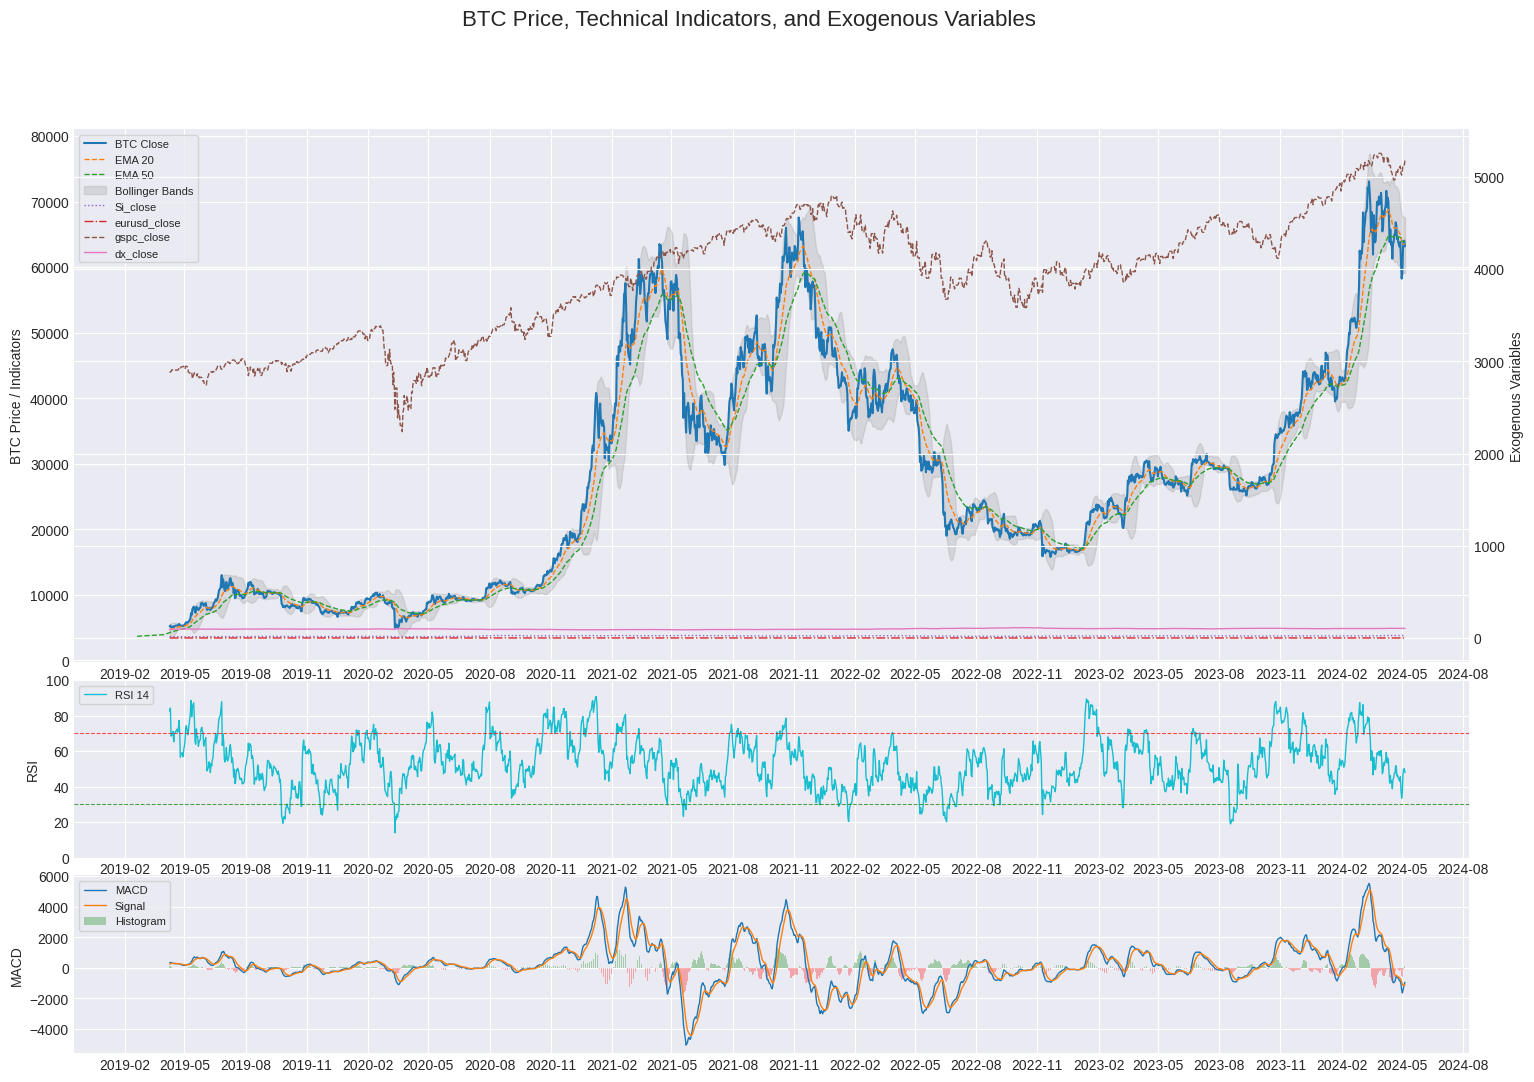

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import numpy as np

def plot_technical_analysis(df_model):
    """Visualize BTC price, technical indicators, and multiple exogenous variables."""
    plt.style.use('seaborn-v0_8-darkgrid')
    fig = plt.figure(figsize=(18, 12), dpi=100)
    gs = GridSpec(3, 1, height_ratios=[3, 1, 1], hspace=0.06)

    # --- Main Price and Technical Indicators ---
    ax1 = fig.add_subplot(gs[0])
    ax1.plot(df_model.index, df_model['close'], label='BTC Close', color='#1f77b4', lw=1.5)
    ax1.plot(df_model.index, df_model['EMA20'], label='EMA 20', color='#ff7f0e', ls='--', lw=1)
    ax1.plot(merged.index, merged['EMA50'], label='EMA 50', color='#2ca02c', ls='--', lw=1)
    ax1.fill_between(df_model.index, df_model['bb_bbl'], df_model['bb_bbh'], color='gray', alpha=0.2, label='Bollinger Bands')

    # --- Exogenous Variables on Secondary Y-Axis ---
    ax1b = ax1.twinx()
    exog_vars = [
        ('Si_close', '#9467bd', ':'),
        ('eurusd_close', '#d62728', '-.'),
        ('gspc_close', '#8c564b', '--'),
        ('dx_close', '#e377c2', '-')
    ]
    for col, color, style in exog_vars:
        if col in df_model.columns:
            ax1b.plot(df_model.index, df_model[col], label=col, color=color, lw=1, ls=style)

    # --- RSI Subplot ---
    ax2 = fig.add_subplot(gs[1], sharex=ax1)
    ax2.plot(df_model.index, df_model['RSI14'], label='RSI 14', color='#17becf', lw=1)
    ax2.axhline(70, color='red', ls='--', lw=0.75, alpha=0.7)
    ax2.axhline(30, color='green', ls='--', lw=0.75, alpha=0.7)
    ax2.set_ylim(0, 100)
    ax2.set_ylabel('RSI')
    ax2.legend(loc='upper left', fontsize=8, frameon=True)

    # --- MACD Subplot ---
    ax3 = fig.add_subplot(gs[2], sharex=ax1)
    ax3.plot(df_model.index, df_model['MACD'], label='MACD', color='#1f77b4', lw=1)
    ax3.plot(df_model.index, df_model['MACD_Signal'], label='Signal', color='#ff7f0e', lw=1)
    ax3.bar(df_model.index, df_model['MACD_Histogram'],
            color=np.where(df_model['MACD_Histogram'] > 0, 'g', 'r'),
            alpha=0.3, label='Histogram')
    ax3.set_ylabel('MACD')
    ax3.legend(loc='upper left', fontsize=8, frameon=True)

    # --- Formatting and Legends ---
    ax1.set_ylabel('BTC Price / Indicators')
    ax1b.set_ylabel('Exogenous Variables')
    ax1.set_xlabel('Date')
    for ax in [ax1, ax2, ax3]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

    # Combine legends from both y-axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1b.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=8, frameon=True)

    plt.suptitle('BTC Price, Technical Indicators, and Exogenous Variables', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


# Usage
plot_technical_analysis(df_model)

**Convert the DataFrame to a CSV file for archival and future modeling applications** (optional)

In [ ]:
# Convert the DataFrame with imputed technical indicators to CSV file

# saving the df DataFrame which should now contain the imputed data
df_model.to_csv('XGBoostBTC.csv', index=True) # Set index=True if you want the date index in the CSV

print("CSV file has been created!")

CSV file has been created!


**9. Model Implemetation**

In [ ]:
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
#data=df_model.copy()

In [ ]:
data=pd.read_csv('XGBoostBTC.csv', parse_dates=['date'], index_col='date')
data

,open,high,low,close,volume,eurusd_close,Si_close,gspc_close,dx_close,RSI14,sma7,sma25,sma99,EMA20,EMA50,bb_bbm,bb_bbh,bb_bbl,MACD,MACD_Histogram,MACD_Signal
date,,,,,,,,,,,,,,,,,,,,,
2019-04-09,5289.92,5289.92,5167.42,5204.96,14722104361,1.13,15.17,2878.20,96.61,82.48,5097.99,4380.61,3905.69,4622.47,4250.53,4462.50,5500.66,3424.35,333.22,93.45,239.77
2019-04-10,5204.11,5421.65,5193.38,5324.55,15504590933,1.13,15.20,2888.21,96.56,84.20,5148.21,4431.64,3920.65,4689.34,4292.64,4527.26,5612.18,3442.34,346.96,85.75,261.21
2019-04-11,5325.08,5354.23,5017.30,5064.49,16555616019,1.13,14.82,2888.32,96.81,68.43,5168.45,4473.21,3931.98,4725.06,4322.91,4579.29,5662.38,3496.20,333.02,57.45,275.57
2019-04-12,5061.20,5103.27,4955.85,5089.54,13675206312,1.13,14.92,2907.41,96.60,69.03,5176.00,4515.49,3944.63,4759.78,4352.98,4631.98,5706.23,3557.72,320.30,35.78,284.52
2019-04-13,5088.85,5127.12,5061.59,5096.59,10823289598,1.13,14.92,2907.41,96.60,69.21,5181.26,4556.51,3957.15,4791.85,4382.14,4685.70,5738.80,3632.59,307.25,18.19,289.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-02,58253.70,59602.30,56937.20,59123.43,32711813559,1.07,26.58,5064.20,105.18,36.40,61734.73,64724.55,59936.71,63509.46,63938.89,63474.95,67849.64,59100.26,-1643.75,-585.69,-1058.06
2024-05-03,59122.30,63320.50,58848.31,62889.84,33172023048,1.07,26.44,5127.79,104.92,47.30,61611.09,64374.89,60168.59,63450.45,63897.75,63428.37,67807.36,59049.38,-1480.85,-338.23,-1142.61
2024-05-04,62891.03,64494.96,62599.35,63891.47,20620477992,1.07,26.44,5127.79,104.92,49.76,61678.57,64164.99,60391.57,63492.45,63897.51,63336.01,67585.84,59086.18,-1256.44,-91.06,-1165.38


[0]	validation_0-rmse:20381.14452
[100]	validation_0-rmse:13166.82692
[200]	validation_0-rmse:8894.18917
[300]	validation_0-rmse:6337.75208
[400]	validation_0-rmse:4868.36959
[500]	validation_0-rmse:3986.76904
[600]	validation_0-rmse:3489.02117
[700]	validation_0-rmse:3202.94994
[800]	validation_0-rmse:3032.43405
[900]	validation_0-rmse:2932.85793
[1000]	validation_0-rmse:2879.02265
[1100]	validation_0-rmse:2848.92407
[1200]	validation_0-rmse:2832.40474
[1300]	validation_0-rmse:2820.73417
[1400]	validation_0-rmse:2813.21190
[1500]	validation_0-rmse:2810.18429
[1600]	validation_0-rmse:2805.57147
[1700]	validation_0-rmse:2803.33632
[1800]	validation_0-rmse:2804.15139
[1900]	validation_0-rmse:2804.39242
[1999]	validation_0-rmse:2806.27016
MAE: 1777.40
R²: 0.96
MAPE: 3.82%


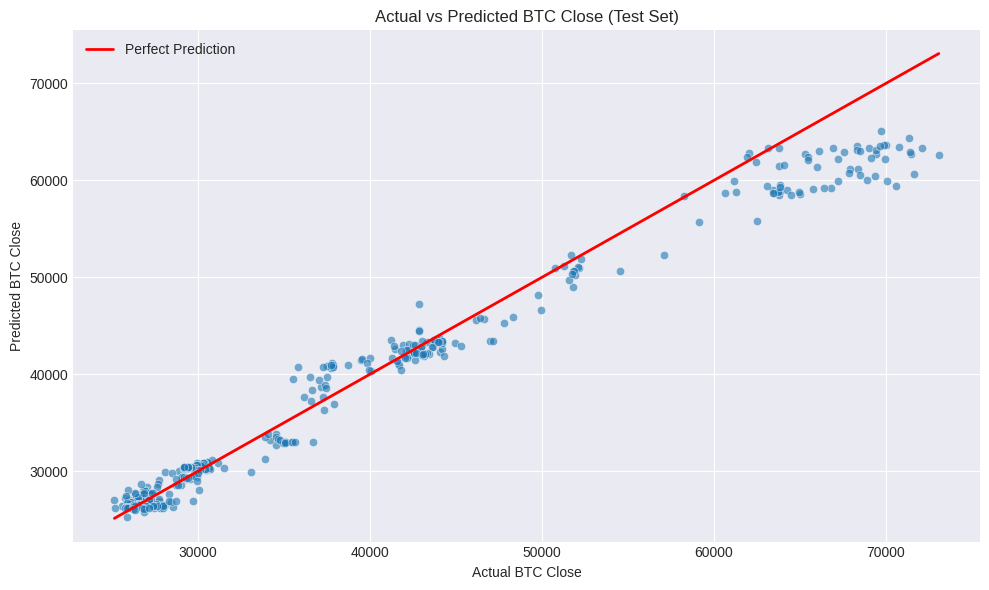

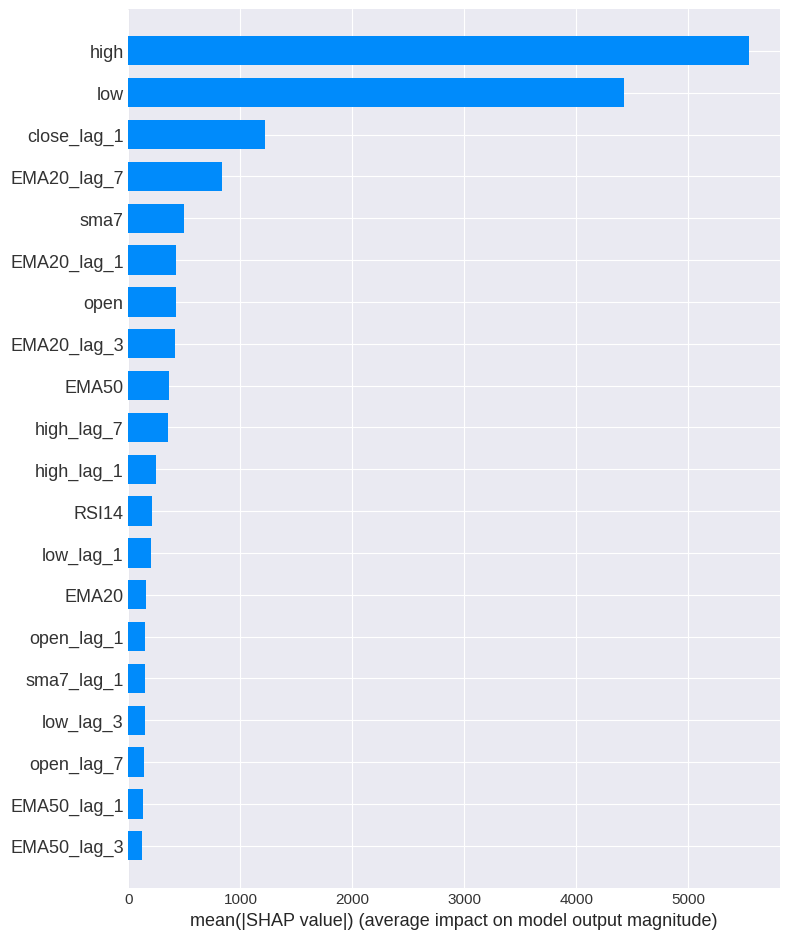

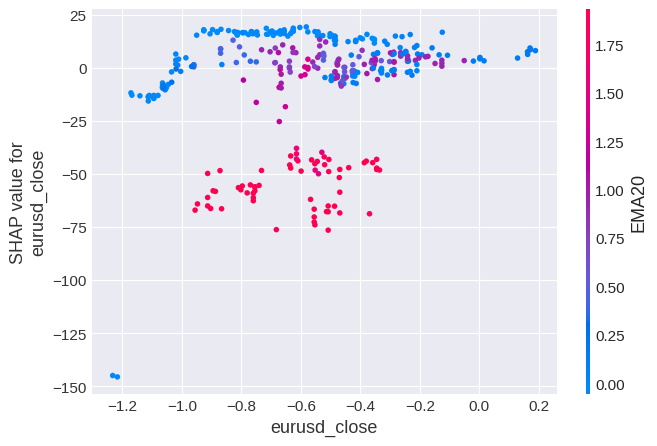

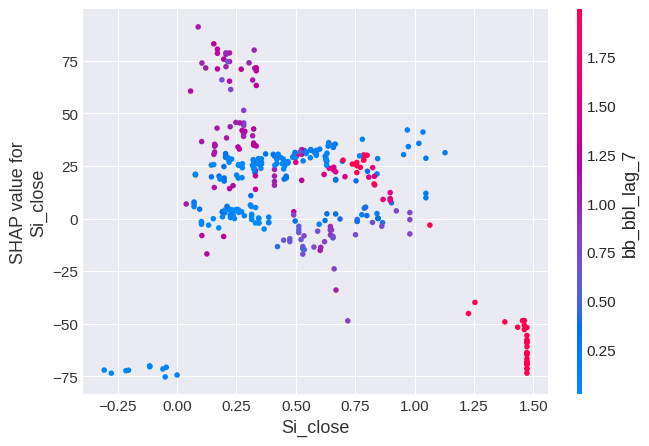

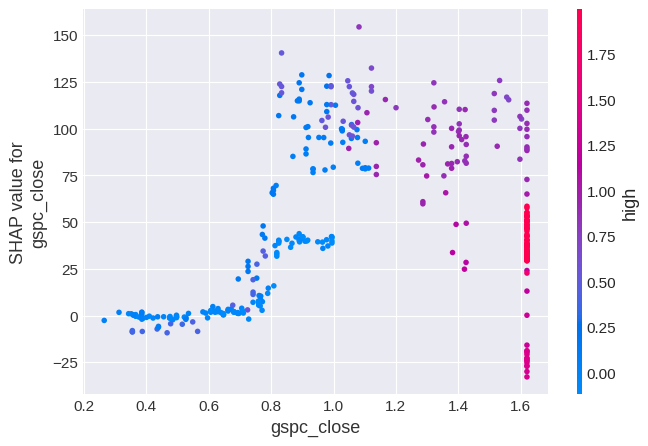

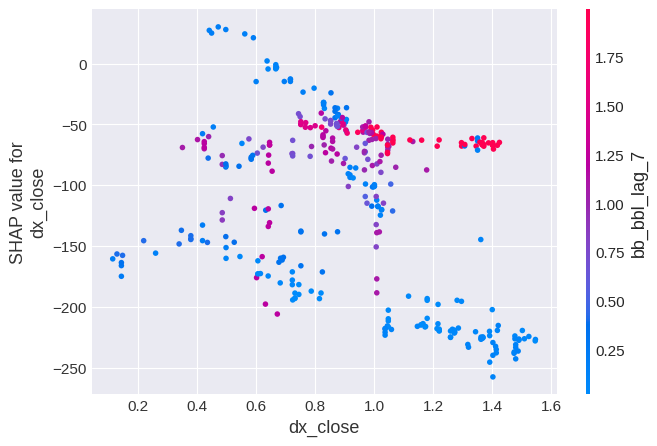

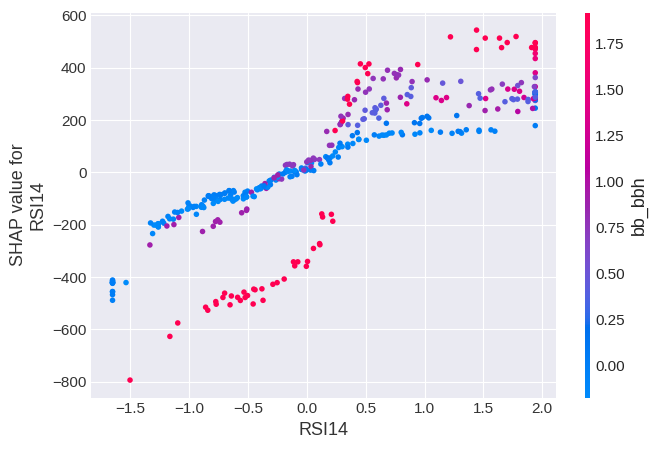

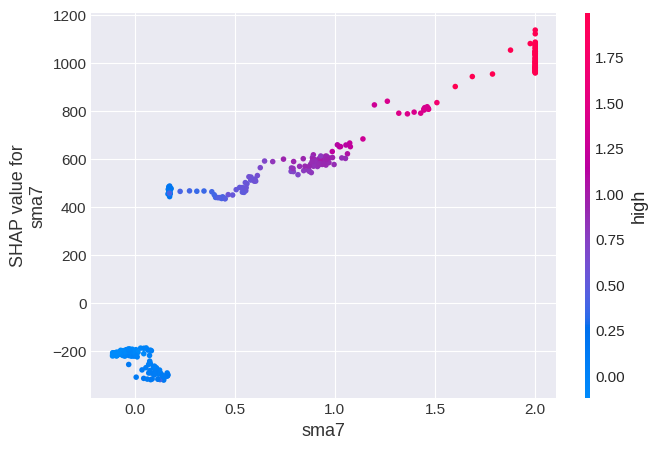

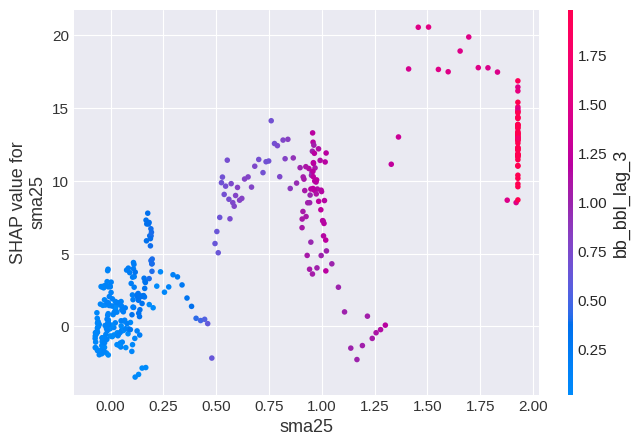

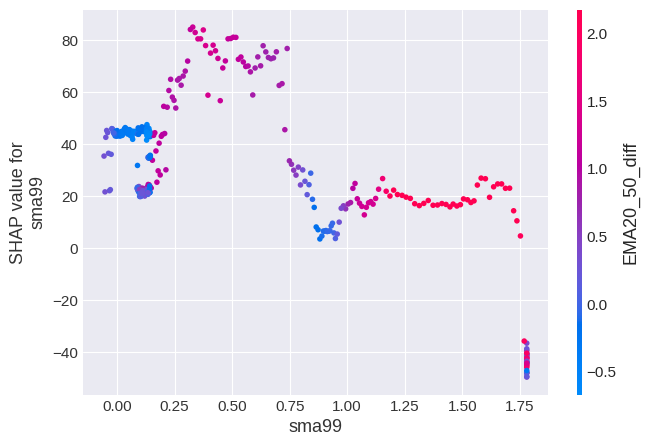

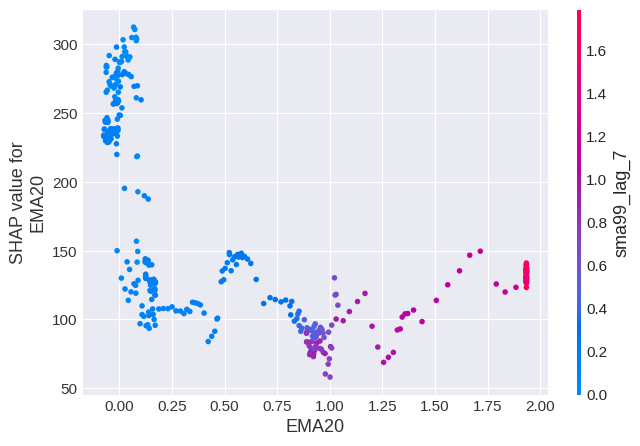

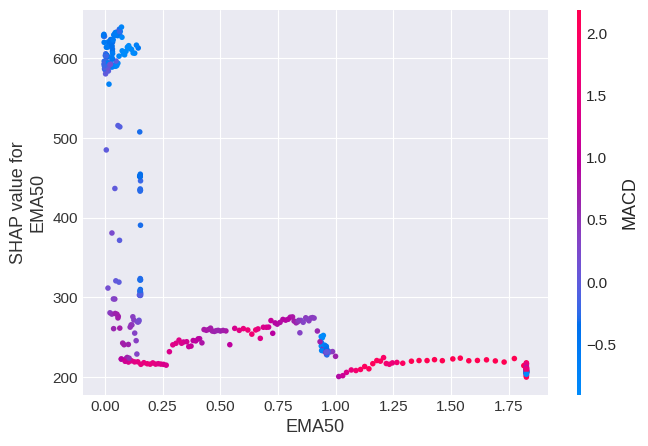

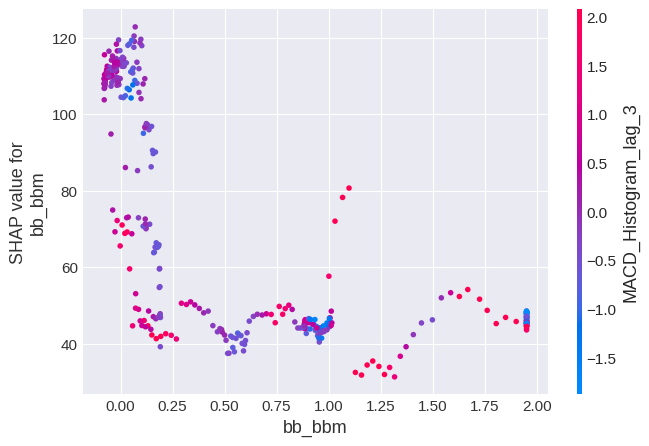

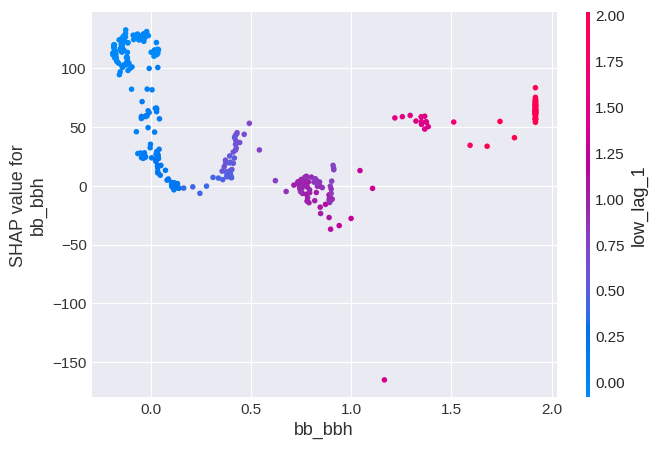

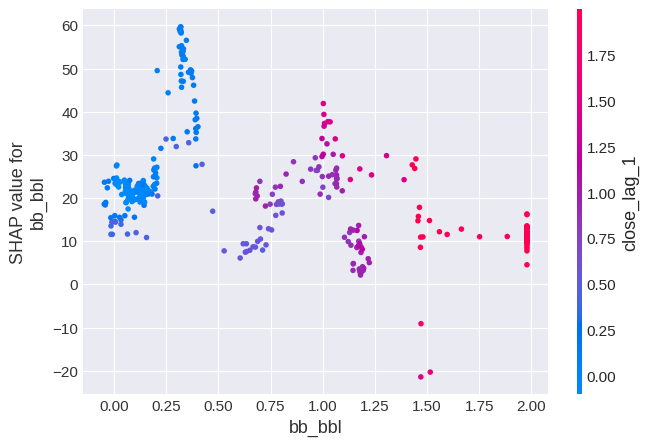

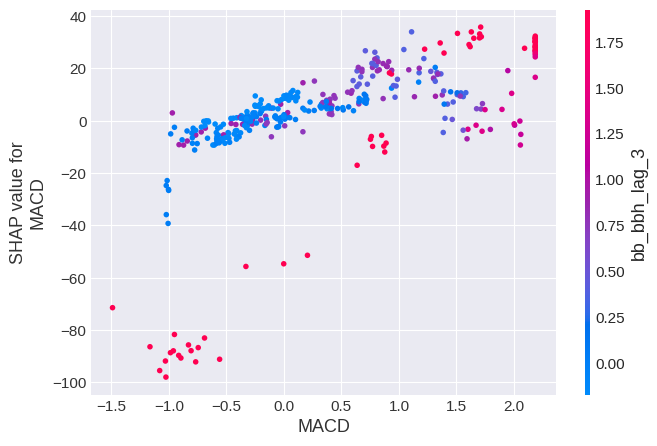

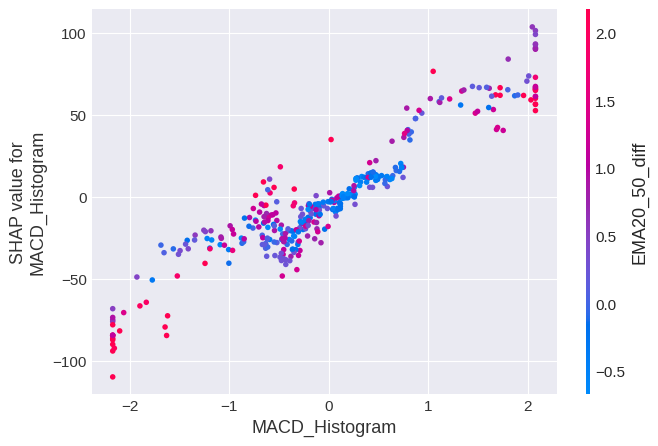

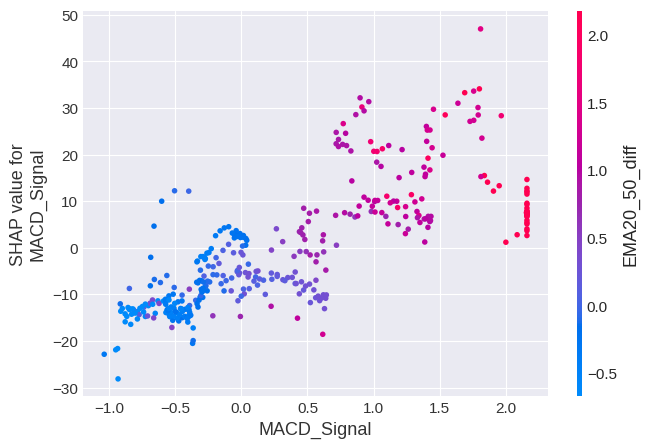

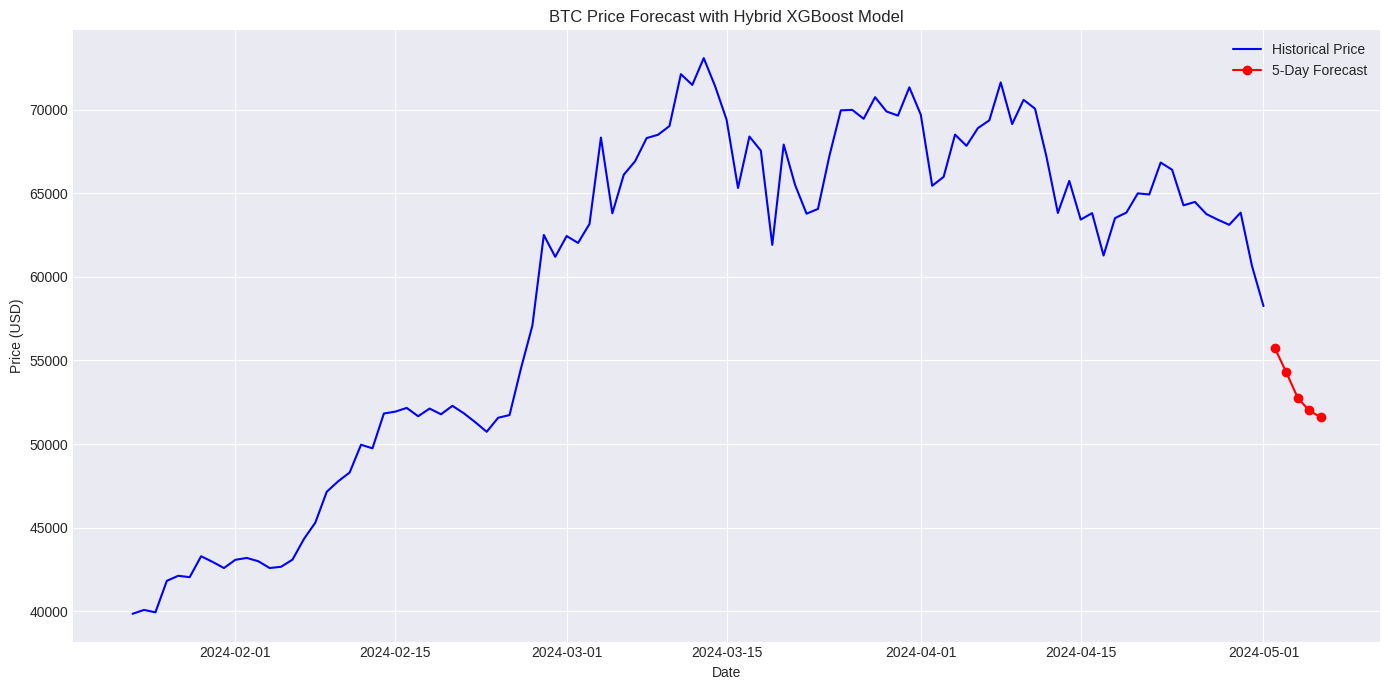

In [ ]:
data=pd.read_csv('XGBoostBTC.csv', parse_dates=['date'], index_col='date')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

# ---------------------------
# 1. Data Preparation & Feature Engineering
# ---------------------------
def prepare_features(data, lags=[1,3,7], forecast_horizon=5):
    """Feature engineering pipeline for time series."""
    # Only apply lags to feature columns, not to the date index
    lag_features = [
        'open', 'high', 'low', 'close', 'volume',
        'eurusd_close', 'Si_close', 'gspc_close', 'dx_close',
        'RSI14', 'sma7', 'sma25', 'sma99', 'EMA20', 'EMA50',
        'bb_bbm', 'bb_bbh', 'bb_bbl', 'MACD', 'MACD_Histogram', 'MACD_Signal'
    ]
    for lag in lags:
        for feature in lag_features:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    # Momentum features
    data['EMA20_50_diff'] = data['EMA20'] - data['EMA50']
    data['MACD_Cross'] = np.where(data['MACD'] > data['MACD_Signal'], 1, -1)

    # Multi-step targets
    for step in range(1, forecast_horizon+1):
        data[f'Target_t+{step}'] = data['close'].shift(-step)

    data.dropna(inplace=True)
    return data

# ---------------------------
# 2. Preprocessing with Outlier Handling
# ---------------------------
def robust_scaling(df, features):
    """Outlier-resistant scaling for features."""
    X = df[features]
    scaler = StandardScaler()
    X_clipped = X.clip(lower=X.quantile(0.05), upper=X.quantile(0.95), axis=1)
    X_scaled = scaler.fit_transform(X_clipped)
    return X_scaled, scaler, X.columns

# ---------------------------
# 3. Model, Validation, and Visualization Pipeline
# ---------------------------
if __name__ == "__main__":
    # Load and prepare data
    data = pd.read_csv('XGBoostBTC.csv', parse_dates=['date'], index_col='date')
    data = prepare_features(data)

    # Define features and targets
    forecast_horizon = 5
    target_cols = [f'Target_t+{i+1}' for i in range(forecast_horizon)]
    features = data.columns.difference(target_cols + ['close'])
    X, scaler, feature_cols = robust_scaling(data, features)
    y = data[target_cols].values

    # Split for validation
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Model training for t+1 prediction
    model = XGBRegressor(
        n_estimators=2000,
        learning_rate=0.005,
        max_depth=7,
        subsample=0.7,
        colsample_bytree=0.6,
        gamma=0.5,
        reg_alpha=0.1,
        reg_lambda=0.1,
        tree_method='gpu_hist',
        random_state=42
    )
    model.fit(X_train, y_train[:, 0], eval_set=[(X_test, y_test[:, 0])], verbose=100)

    # Predictions and metrics for t+1
    predictions = model.predict(X_test)
    print(f"MAE: {mean_absolute_error(y_test[:, 0], predictions):.2f}")
    print(f"R²: {r2_score(y_test[:, 0], predictions):.2f}")
    print(f"MAPE: {mean_absolute_percentage_error(y_test[:, 0], predictions)*100:.2f}%")

    # Actual vs Predicted Plot
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=y_test[:, 0], y=predictions, alpha=0.6)
    plt.plot([y_test[:, 0].min(), y_test[:, 0].max()], [y_test[:, 0].min(), y_test[:, 0].max()], color='red', lw=2, label='Perfect Prediction')
    plt.title('Actual vs Predicted BTC Close (Test Set)')
    plt.xlabel('Actual BTC Close')
    plt.ylabel('Predicted BTC Close')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Feature importance with SHAP
    # Feature importance and dependence plots with SHAP
try:
    explainer = shap.TreeExplainer(model)
    X_df = pd.DataFrame(X_test, columns=features)
    shap_values = explainer.shap_values(X_df)

    # Bar summary plot for global importance
    shap.summary_plot(shap_values, X_df, plot_type='bar')

    # List of features for dependence plots
    dependence_features = [
        'eurusd_close', 'Si_close', 'gspc_close', 'dx_close', 'RSI14',
        'sma7', 'sma25', 'sma99', 'EMA20', 'EMA50',
        'bb_bbm', 'bb_bbh', 'bb_bbl',
        'MACD', 'MACD_Histogram', 'MACD_Signal'
    ]

    # Generate dependence plots for each feature
    for feat in dependence_features:
        if feat in X_df.columns:
            shap.dependence_plot(feat, shap_values, X_df)
except Exception as e:
    print(f"SHAP error: {e}")



    # Multi-step hybrid forecasting (optional)
    # ... (see previous code for HybridForecaster class if needed)

    # --- Future Prediction and Visualization ---




# 1. Generate future predictions using the hybrid forecaster
last_observation = X[-1]  # Last available feature vector
future_preds = forecaster.predict(last_observation)

# 2. Prepare future dates for plotting
forecast_horizon = len(future_preds)
future_dates = pd.date_range(start=data.index[-1], periods=forecast_horizon+1, freq='D')[1:]

# 3. Visualization: Actual last 100 closes + 5-day forecast
plt.figure(figsize=(14, 7))
plt.plot(data.index[-100:], data['close'].values[-100:], label='Historical Price', color='blue')
plt.plot(future_dates, future_preds, marker='o', label=f'{forecast_horizon}-Day Forecast', color='red')
plt.title('BTC Price Forecast with Hybrid XGBoost Model')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
data=pd.read_csv('XGBoostBTC.csv', parse_dates=['date'], index_col='date')